# Deep Learning with Keras on Amazon SageMaker

Amazon SageMaker is a modular, fully managed Machine Learning service that lets you easily build, train and deploy models at any scale.

In this notebook, we'll use Keras (with the TensorFlow backend) to build a simple Convolutional Neural Network (CNN). We'll then train it to classify the Fashion-MNIST image data set. Fashion-MNIST is a Zalando dataset consisting of a training set of 60,000 examples and a validation set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes: it's a drop-in replacement for MNIST.

This notebook modified from AIM410R/R1 session at AWS re:Invent 2019. https://gitlab.com/juliensimon/aim410

## Resources
  * Amazon SageMaker documentation [ https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html ]
  * SageMaker SDK 
    * Code [ https://github.com/aws/sagemaker-python-sdk ] 
    * Documentation [ https://sagemaker.readthedocs.io/ ]
  * Fashion-MNIST [ https://github.com/zalandoresearch/fashion-mnist ] 
  * Keras documentation [ https://keras.io/ ]
  * Numpy documentation [ https://docs.scipy.org/doc/numpy/index.html ]

## Install and import packages

In [4]:
%%sh
pip install --upgrade pip
pip install smdebug smdebug-rulesconfig==0.1.4 # install SageMaker Debugger

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages (20.2.3)


In [ ]:
# Restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [2]:
import sagemaker

sess = sagemaker.Session()
role = sagemaker.get_execution_role()

## Download the Fashion-MNIST dataset

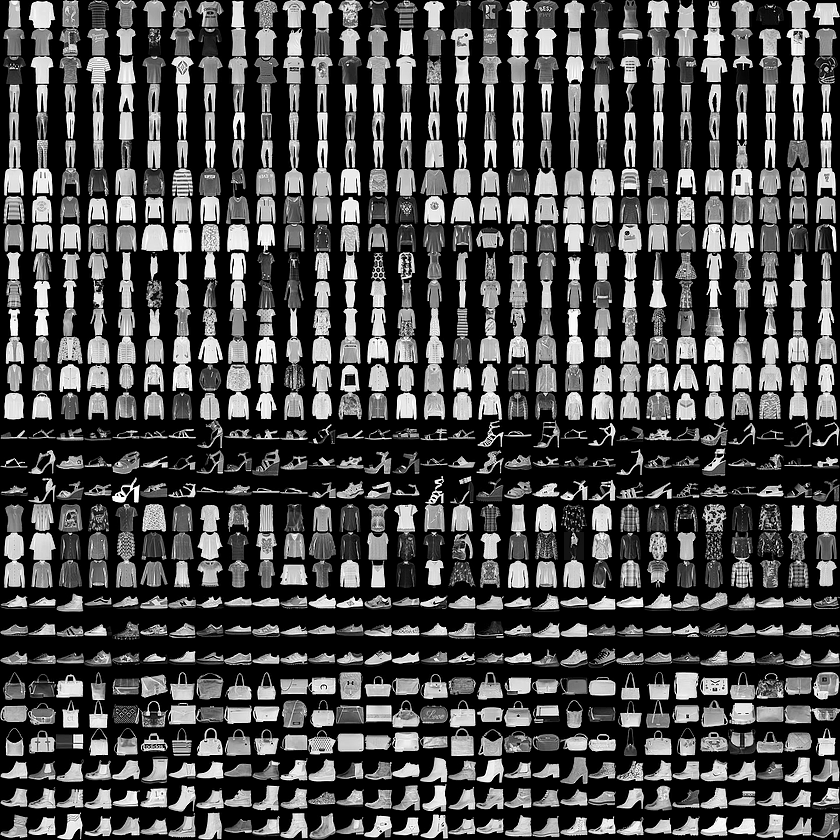

In [3]:
from IPython.display import Image
Image("fashion-mnist-sprite.png")

First, we need to download the data set from the Internet. Fortunately, Keras provides a simple way to do this. The data set is already split (training and validation), with separate Numpy arrays for samples and labels. 

We create a local directory, and save the training and validation data sets separately.

In [4]:
import os
import keras
import numpy as np
from keras.datasets import fashion_mnist

(x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()

os.makedirs("./data", exist_ok = True)

np.savez('./data/training', image=x_train, label=y_train)
np.savez('./data/validation', image=x_val, label=y_val)

Using TensorFlow backend.



4423680/4422102 [==============================] - 2s 0us/step


In [5]:
%%sh
ls data

training.npz
validation.npz


## Take a look at our Keras code

What are these environment variables and why are they important? Well, they will be automatically passed to our script by SageMaker, so that we know where the data sets are, where to save the model, and how many GPUs we have. So, if you write your code this way, **there won't be anything to change** to run it on SageMaker.

This feature is called '**script mode**', it's the recommended way to work with built-in frameworks on SageMaker.

In [6]:
%%sh
pygmentize mnist_keras_tf.py

import argparse, os
import numpy as np

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import multi_gpu_model, to_categorical

import subprocess
import sys

# Script mode doesn't support requirements.txt
# Here's the workaround ;)
def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])

if __name__ == '__main__':
    
    # Keras-metrics brings additional metrics: precision, recall, f1
    install('keras-metrics')
    import keras_metrics
    
    parser = argparse.ArgumentParser()

    parser.add_argument('--epochs', type=i

The main steps are:
  * receive and parse command line arguments: five hyper parameters, and four environment variables
  * load the data sets
  * make sure data sets have the right shape for TensorFlow (channels last)
  * normalize data sets, i.e. tranform [0-255] pixel values to [0-1] values
  * one-hot encode category labels (not familiar with this? More info: [ https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/ ])
  * Build a Sequential model in Keras: two convolution block with max pooling, followed by a fully connected layer with dropout, and a final classification layer. Don't worry if this sounds like gibberish, it's not our focus today
  * Train the model, leveraging multiple GPUs if they're available.
  * Print statistics
  * Save the model in TensorFlow serving format
  

## Train with Tensorflow on the notebook instance (aka 'local mode')

Let's test our code inside the built-in TensorFlow environment provided by SageMaker. For fast experimentation, let's use local mode to train on the local notebook instance.

In [7]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(entry_point='mnist_keras_tf.py', 
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='local',
                          framework_version='1.15', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={'epochs': 1}
                         )

Now, let's define the local location of the training and validation data sets

In [8]:
local_training_input_path   = 'file://data/training.npz'
local_validation_input_path = 'file://data/validation.npz'

Let's train!

In [9]:
tf_estimator.fit({'training': local_training_input_path, 'validation': local_validation_input_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Creating tmplp7zcumj_algo-1-quw5a_1 ... 
Attaching to tmplp7zcumj_algo-1-quw5a_12mdone
algo-1-quw5a_1  | WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.
algo-1-quw5a_1  | 
algo-1-quw5a_1  | 2020-09-22 21:30:39,826 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-quw5a_1  | 2020-09-22 21:30:39,833 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-quw5a_1  | 2020-09-22 21:30:41,115 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-quw5a_1  | 2020-09-22 21:30:41,132 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-quw5a_1  | 2020-09-22 21:30:41,149 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-quw5a_1  | 2020-09-22 21:30:41,160 sagema

algo-1-quw5a_1  | Installing collected packages: keras-metrics
algo-1-quw5a_1  | Successfully installed keras-metrics-1.1.0
algo-1-quw5a_1  | x_train shape: (60000, 28, 28, 1)
algo-1-quw5a_1  | 60000 train samples
algo-1-quw5a_1  | 10000 test samples
algo-1-quw5a_1  | Model: "sequential"
algo-1-quw5a_1  | _________________________________________________________________
algo-1-quw5a_1  | Layer (type)                 Output Shape              Param #   
algo-1-quw5a_1  | =================================================================
algo-1-quw5a_1  | conv2d (Conv2D)              (None, 28, 28, 64)        640       
algo-1-quw5a_1  | _________________________________________________________________
algo-1-quw5a_1  | batch_normalization (BatchNo (None, 28, 28, 64)        256       
algo-1-quw5a_1  | _________________________________________________________________
algo-1-quw5a_1  | activation (Activation)      (None, 28, 28, 64)        0         
algo-1-quw5a_1  | _____________________

OK, our job runs fine locally. Let's now run the same job on a managed instance.

## Upload the data set to S3

SageMaker training instances expect data sets to be stored in Amazon S3, so let's upload them there. We could use boto3 to do this, but the SageMaker SDK includes a simple function: [Session.upload_data()](https://sagemaker.readthedocs.io/en/stable/session.html).



*Note: for high-performance workloads, Amazon EFS and Amazon FSx for Lustre are now also supported. More info [here](https://aws.amazon.com/blogs/machine-learning/speed-up-training-on-amazon-sagemaker-using-amazon-efs-or-amazon-fsx-for-lustre-file-systems/).

In [10]:
prefix = 'keras-fashion-mnist'

# Upload the training data set to 'keras-fashion-mnist/training'
training_input_path   = sess.upload_data('data/training.npz', key_prefix=prefix+'/training')

# Upload the validation data set to 'keras-fashion-mnist/validation'
validation_input_path = sess.upload_data('data/validation.npz', key_prefix=prefix+'/validation')

print(training_input_path)
print(validation_input_path)

s3://sagemaker-us-west-2-696049136671/keras-fashion-mnist/training/training.npz
s3://sagemaker-us-west-2-696049136671/keras-fashion-mnist/validation/validation.npz


We're done with our data set. Of course, in real life, much more work would be needed for data cleaning and preparation!

## Train with Managed Spot Training, and enable debugging with Amazon SageMaker Debugger

EC2 Spot Instances have long been a great cost optimization feature, and spot training is now available on SageMaker.
This blog [post](https://aws.amazon.com/blogs/aws/managed-spot-training-save-up-to-90-on-your-amazon-sagemaker-training-jobs/) has more info.

We're also using Amazon SageMaker Debugger to check for unwanted training conditions. **ZERO KERAS CODE NEEDED!**

In [14]:
# Configure a managed training job for 'mnist_keras_tf.py', 
# using a single p3.2xlarge spot instance running TensorFlow 1.15 in script mode

from sagemaker.tensorflow import TensorFlow
from sagemaker.debugger import Rule, rule_configs

tf_estimator = TensorFlow(entry_point='mnist_keras_tf.py', 
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.p3.2xlarge',
                          framework_version='1.15', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={'epochs': 5}
                          train_use_spot_instances=True,        # Use spot instance
                          train_max_run=480,                    # Max training time
                          train_max_wait=720,                  # Max training time + spot waiting time
                          rules = [Rule.sagemaker(rule_configs.loss_not_decreasing()),
                                   Rule.sagemaker(rule_configs.overfit())]
                         )

Let's train!

In [15]:
# Train on the training and validation data sets stored in S3

tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-22 21:52:25 Starting - Starting the training job...
2020-09-22 21:52:50 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*            Overfit: InProgress        
*
****************************************
...
2020-09-22 21:53:10 Starting - Insufficient capacity error from EC2 while launching instances, retrying!.........
2020-09-22 21:54:55 Starting - Preparing the instances for training............
2020-09-22 21:56:56 Downloading - Downloading input data
2020-09-22 21:56:56 Training - Downloading the training image...
2020-09-22 21:57:20 Training - Training image download completed. Training in progress..WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2020-09-22 21:57:24,103 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_containe

Epoch 1/10
[2020-09-22 21:57:32.555 ip-10-0-96-99.us-west-2.compute.internal:34 INFO hook.py:398] Monitoring the collections: losses, metrics, sm_metrics
#015  128/60000 [..............................] - ETA: 27:43 - loss: 3.2131 - acc: 0.1094 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1024/60000 [..............................] - ETA: 3:27 - loss: 2.5

#015  128/60000 [..............................] - ETA: 3s - loss: 0.2251 - acc: 0.9219 - precision: 1.0000 - recall: 0.8462 - f1_score: 0.9167#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1280/60000 [..............................] - ETA: 2s - loss: 0.2479 - acc: 0.9164 - precision: 0.9089 - recall: 0.8929 - f1_score: 0.8916#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015  128/60000 [..............................] - ETA: 3s - loss: 0.2124 - acc: 0.9141 - precision: 0.7692 - recall: 0.8333 - f1_score: 0.8000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1152/60000 [..............................] - ETA: 2s - loss: 0.2069 - acc: 0.9201 - precision: 0.8670 - recall: 0.8400 - f1_score: 0.8406#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

#015  128/60000 [..............................] - ETA: 4s - loss: 0.1063 - acc: 0.9688 - precision: 1.0000 - recall: 0.9286 - f1_score: 0.9630#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 1152/60000 [..............................] - ETA: 3s - loss: 0.1323 - acc: 0.9514 - precision: 0.9095 - recall: 0.8873 - f1_score: 0.8941#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0


2020-09-22 21:58:23 Uploading - Uploading generated training model
2020-09-22 21:58:23 Completed - Training job completed
Training seconds: 109
Billable seconds: 33
Managed Spot Training savings: 69.7%


This will take about 10 minutes. Please take a look at the training log. The first few lines show SageMaker preparing the managed instance. While the job is training, you can also look at metrics in the AWS console for SageMaker, and at the training log in the the AWS console for CloudWatch Logs.

Let's check the status of the debug rules we configured.

In [16]:
job_name = tf_estimator.latest_training_job.name
client = tf_estimator.sagemaker_session.sagemaker_client

description = client.describe_training_job(TrainingJobName=job_name)

In [17]:
import pprint 
for status in description['DebugRuleEvaluationStatuses']:
    status.pop('LastModifiedTime')
    status.pop('RuleEvaluationJobArn')
    pprint.pprint(status)

{'RuleConfigurationName': 'LossNotDecreasing',
 'RuleEvaluationStatus': 'NoIssuesFound'}
{'RuleConfigurationName': 'Overfit',
 'RuleEvaluationStatus': 'IssuesFound',
 'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule Overfit '
                  'at step 5211 resulted in the condition being met\n'}


Let's also look at tensor information saved in S3.

In [18]:
s3_output_path = description["DebugHookConfig"]["S3OutputPath"] + job_name + '/' + 'debug-output/'

print(s3_output_path)

s3://sagemaker-us-west-2-696049136671/tensorflow-training-2020-09-22-21-52-25-249/debug-output/


In [20]:
import smdebug
from smdebug.trials import create_trial

trial = create_trial(s3_output_path)
trial

[2020-09-22 22:03:16.413 ip-172-16-48-5:7447 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-west-2-696049136671/tensorflow-training-2020-09-22-21-52-25-249/debug-output/
[2020-09-22 22:03:18.357 ip-172-16-48-5:7447 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-09-22 22:03:19.388 ip-172-16-48-5:7447 INFO trial.py:210] Loaded all steps


<smdebug.trials.s3_trial.S3Trial object at 0x7fd4ca783b70>:(
    name=,
    path=s3://sagemaker-us-west-2-696049136671/tensorflow-training-2020-09-22-21-52-25-249/debug-output/,
    steps=[0, 469, 547, 579, 1095, 1158, 1643, 1737, 2191, 2316, 2739, 2895, 3287, 3474, 3783, 3835, 4053, 4383, 4632, 4931, 5211, 5479, 5690],
    collections=['default', 'optimizer_variables', 'outputs', 'gradients', 'losses', 'inputs', 'layers', 'sm_metrics', 'biases', 'metrics', 'weights', 'all'],
    tensor_names=['acc', 'batch', 'f1_score', 'loss', 'precision', 'recall', 'size', 'val_acc', 'val_f1_score', 'val_loss', 'val_precision', 'val_recall'],
)

In [21]:
trial.tensor_names()

['acc',
 'batch',
 'f1_score',
 'loss',
 'precision',
 'recall',
 'size',
 'val_acc',
 'val_f1_score',
 'val_loss',
 'val_precision',
 'val_recall']

In [22]:
loss_values = trial.tensor('loss').values()

In [23]:
loss_values

{0: array([3.2130563], dtype=float32),
 469: array([0.5607907], dtype=float32),
 547: array([0.43769043]),
 579: array([0.25506276], dtype=float32),
 1095: array([0.29021837]),
 1158: array([0.3541215], dtype=float32),
 1643: array([0.25003224]),
 1737: array([0.28218466], dtype=float32),
 2191: array([0.22686781]),
 2316: array([0.18756296], dtype=float32),
 2739: array([0.20356101]),
 2895: array([0.18951751], dtype=float32),
 3287: array([0.186848]),
 3474: array([0.17154653], dtype=float32),
 3783: array([0.18892257], dtype=float32),
 3835: array([0.17003651]),
 4053: array([0.1236653], dtype=float32),
 4383: array([0.15724031]),
 4632: array([0.10827723], dtype=float32),
 4931: array([0.14548453]),
 5211: array([0.13614063], dtype=float32),
 5479: array([0.13351721]),
 5690: array([0.21782304], dtype=float32)}

## Automatic Model Tuning

Automatic model tuning is a great feature that helps you find automatically the best hyper parameters for your training job.

This blog [post](https://aws.amazon.com/blogs/machine-learning/amazon-sagemaker-automatic-model-tuning-now-supports-random-search-and-hyperparameter-scaling/) has more info.

First, let's define parameter ranges

In [24]:
# Define parameter ranges :

from sagemaker.tuner import IntegerParameter, ContinuousParameter

hyperparameter_ranges = {
    'epochs' :       IntegerParameter(5, 10),
    'learning-rate': ContinuousParameter(0.001, 0.1, scaling_type='ReverseLogarithmic'), 
    'batch-size':    IntegerParameter(32, 1024),
    'filters':       IntegerParameter(4, 64),
    'dense-layer':   IntegerParameter(32, 1024),
    'dropout':       ContinuousParameter(0.2, 0.8)
}

The next step is to define the metric we're optimizing for, in this case we want to maximize the validation accuracy. We also grab other metrics from the training log.

In [25]:
objective_metric_name = 'validation_accuracy'

objective_type = 'Maximize'

metric_definitions = [
    {'Name': 'training_loss',        'Regex': 'loss: ([0-9\\.]+)'},
    {'Name': 'training_accuracy',    'Regex': 'acc: ([0-9\\.]+)'},
    {'Name': 'validation_loss',      'Regex': 'val_loss: ([0-9\\.]+)'},
    {'Name': 'validation_accuracy',  'Regex': 'val_acc: ([0-9\\.]+)'},
    {'Name': 'training_precision',   'Regex': 'precision: ([0-9\\.]+)'},
    {'Name': 'training_recall',      'Regex': 'recall: ([0-9\\.]+)'},
    {'Name': 'training_f1_score',    'Regex': 'f1_score: ([0-9\\.]+)'},
    {'Name': 'validation_precision', 'Regex': 'val_precision: ([0-9\\.]+)'},
    {'Name': 'validation_recall',    'Regex': 'val_recall: ([0-9\\.]+)'},
    {'Name': 'validation_f1_score',  'Regex': 'val_f1_score: ([0-9\\.]+)'}
]

Then, it's time to put everything together, and configure the tuning job. Same estimator as above, without the debugging job.

In [26]:
tf_estimator = TensorFlow(entry_point='mnist_keras_tf.py', 
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.p3.2xlarge',
                          framework_version='1.15', 
                          py_version='py3',
                          script_mode=True,
                          train_use_spot_instances=True,        # Use spot instance
                          train_max_run=600,                    # Max training time
                          train_max_wait=720                   # Max training time + spot waiting time
                         )

In [27]:
from sagemaker.tuner import HyperparameterTuner

# Configure a training job using the Tensorflow estimator, the parameter ranges and the metric defined above.
# Let's run three individual jobs, one by one.

tuner = HyperparameterTuner(tf_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=3,
                            max_parallel_jobs=1,
                            objective_type=objective_type)

Finally, let's launch the tuning job, just like a normal estimator.

In [28]:
# Launch the tuning job, passing the location of the data sets in S3.

tuner.fit({'training': training_input_path, 'validation': validation_input_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


While the job is running, you can view it in the AWS console for SageMaker: individual jobs (and their logs), best training job so far, etc.

Of course, you can also inspect the job programatically using [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html) : *decribe_hyper_parameter_training_job()*, etc.

## Inspect jobs with Amazon SageMaker Experiments

Model tuning automatically creates a new experiment, and pushes information for each job. 

**ZERO KERAS CODE NEEDED!**

Run the following cell to see the status of the automatic model tuning job. Rerun the cell to see updated job statuses. 

Note TrainingJobStatus may be 'InProgress' for one or more jobs. Status is 'Completed' when jobs are done.

In [45]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
    sagemaker_session=sess, 
    hyperparameter_tuning_job_name=tuner.latest_tuning_job.name
)

df = exp.dataframe()
df

batch-size  dense-layer   dropout  epochs  filters  learning-rate  \
0       907.0        310.0  0.604244    15.0     47.0       0.080954   
1       917.0        300.0  0.610244    15.0     46.0       0.081913   
2       209.0        725.0  0.330757     7.0     58.0       0.049883   

                                TrainingJobName TrainingJobStatus  \
0  tensorflow-training-200922-2203-003-ab446c7c           Stopped   
1  tensorflow-training-200922-2203-002-bb66486f           Stopped   
2  tensorflow-training-200922-2203-001-7984dd85         Completed   

   FinalObjectiveValue         TrainingStartTime           TrainingEndTime  \
0                  NaN                       NaT 2020-09-22 22:30:55+00:00   
1                  NaN                       NaT 2020-09-22 22:30:33+00:00   
2               0.8832 2020-09-22 22:07:27+00:00 2020-09-22 22:09:41+00:00   

   TrainingElapsedTimeSeconds  
0                         NaN  
1                         NaN  
2                       134.0

Pandas is the Swiss army knife for columnar data. Let's just look at the top job.

In [46]:
best_job = df.sort_values('FinalObjectiveValue', ascending=0)[:1]
best_job

batch-size  dense-layer   dropout  epochs  filters  learning-rate  \
2       209.0        725.0  0.330757     7.0     58.0       0.049883   

                                TrainingJobName TrainingJobStatus  \
2  tensorflow-training-200922-2203-001-7984dd85         Completed   

   FinalObjectiveValue         TrainingStartTime           TrainingEndTime  \
2               0.8832 2020-09-22 22:07:27+00:00 2020-09-22 22:09:41+00:00   

   TrainingElapsedTimeSeconds  
2                       134.0

In [47]:
best_job_name = best_job['TrainingJobName'].to_string(index=False).strip()
best_job_name

'tensorflow-training-200922-2203-001-7984dd85'

In [48]:
import boto3
sm = boto3.client('sagemaker')

In [49]:
best_job = sm.describe_training_job(TrainingJobName=best_job_name)

best_model_artefact = best_job['ModelArtifacts']['S3ModelArtifacts']
best_model_container = best_job['AlgorithmSpecification']['TrainingImage']

print(best_job_name)
print(best_model_artefact)
print(best_model_container)

tensorflow-training-200922-2203-001-7984dd85
s3://sagemaker-us-west-2-696049136671/tensorflow-training-200922-2203-001-7984dd85/output/model.tar.gz
763104351884.dkr.ecr.us-west-2.amazonaws.com/tensorflow-training:1.15-gpu-py3


## Deploy the best model, enabling data capture with Amazon SageMaker Model Monitor

This is where we want to save captured data.

In [50]:
bucket = sess.default_bucket()
prefix = '/ModelMonitorDEMO/'
s3_capture_path = 's3://' + bucket + prefix + best_job_name + '/'

print(s3_capture_path)

s3://sagemaker-us-west-2-696049136671/ModelMonitorDEMO/tensorflow-training-200922-2203-001-7984dd85/


By default, we will capture 100% of model inputs and outputs. Of course, this is configurable.

And you guessed it... **ZERO KERAS CODE NEEDED!**

In [51]:
from sagemaker.model_monitor import DataCaptureConfig

cap = DataCaptureConfig(
    enable_capture=True,
    destination_s3_uri=s3_capture_path
)

In [52]:
endpoint_name = best_job_name + '-ep'

best_model_predictor = tuner.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.xlarge', 
    endpoint_name=endpoint_name,
    data_capture_config=cap)

2020-09-22 22:09:41 Starting - Preparing the instances for training
2020-09-22 22:09:41 Downloading - Downloading input data
2020-09-22 22:09:41 Training - Training image download completed. Training in progress.
2020-09-22 22:09:41 Uploading - Uploading generated training model
2020-09-22 22:09:41 Completed - Training job completed

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-09-22 22:08:57,256 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2020-09-22 22:08:57,257 sagemaker-training-toolkit INFO     Failed to parse hyperparameter _tuning_objective_metric value validation_accuracy to Json.
Returning the value itself
2020-09-22 22:08:57,283 sagemaker_tensorflow_container.training INFO     Appending the training job name to model_dir: s3://sagemaker-us-west-2-696049136671/tensorflow-training-2020-09-22-22-03-49-166/model/tensorflow-training-200922-2203-001-7984dd85/model
2020-09-22 22:08:57,681 sagemaker-training-toolkit INFO     Failed to parse hyperparameter _tuning_objective_metric value validation_accuracy to Json.
Returning the value itself
2020-09-22 22:08:57,705 sagemaker-training-toolkit INFO     Failed to parse hyperparameter _tuning_objective_metric value validation_accuracy to Json.
Returning the value itself
2020-09-22 22:08:57,729 sagemaker-training-toolkit INFO     Failed to parse hyperparamet

-------------!

## Predict with best model

Predicted labels are: [3 9 5 5 8 8 7 9 5 9]


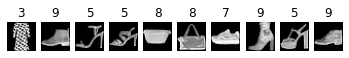

In [53]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 10
indices = random.sample(range(x_val.shape[0] - 1), num_samples)
images = x_val[indices]/255
labels = y_val[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
prediction = best_model_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction)
predicted_labels = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_labels))

Now let's predict the validation dataset 250 samples at a time, storing labels and predicted labels as we go.

In [54]:
%%time
num_samples = 250
all_labels=[]
all_predicted_labels=[]

import sys

for i in range(0,x_val.shape[0] - 1,num_samples):
    sys.stdout.write(str(i)+' ')
    indices = range(i,i+num_samples)
    images = x_val[indices]/255
    labels = y_val[indices]
    prediction = best_model_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
    prediction = np.array(prediction)
    predicted_labels = prediction.argmax(axis=1)
    all_labels.extend(labels)
    all_predicted_labels.extend(predicted_labels)

0 250 500 750 1000 1250 1500 1750 2000 2250 2500 2750 3000 3250 3500 3750 4000 4250 4500 4750 5000 5250 5500 5750 6000 6250 6500 6750 7000 7250 7500 7750 8000 8250 8500 8750 9000 9250 9500 9750 CPU times: user 16.5 s, sys: 421 ms, total: 16.9 s
Wall time: 27.8 s


Let's build the confusion matrix, to compare predicted labels with real labels for each class.

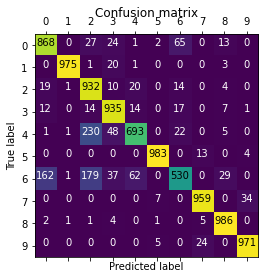

In [55]:
import sklearn
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_predicted_labels)
plt.matshow(cm)
plt.title('Confusion matrix')
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] < thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
classes = range(10) # Labels are sorted 
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.grid(False)
plt.show()

Let's check that we captured data (you may have to wait a minute or two for files to show up).

In [56]:
%%sh -s "$s3_capture_path"

aws s3 ls --recursive $1

2020-09-22 22:39:39   11541676 ModelMonitorDEMO/tensorflow-training-200922-2203-001-7984dd85/tensorflow-training-200922-2203-001-7984dd85-ep/AllTraffic/2020/09/22/22/39-24-339-1f7fa20c-7e00-495c-ba66-7d1b0caa092c.jsonl


In [57]:
%%sh -s "$s3_capture_path"

aws s3 cp --recursive $1 .

download: s3://sagemaker-us-west-2-696049136671/ModelMonitorDEMO/tensorflow-training-200922-2203-001-7984dd85/tensorflow-training-200922-2203-001-7984dd85-ep/AllTraffic/2020/09/22/22/39-31-958-6ba3989c-08fc-490e-93db-b7218401f574.jsonl to tensorflow-training-200922-2203-001-7984dd85-ep/AllTraffic/2020/09/22/22/39-31-958-6ba3989c-08fc-490e-93db-b7218401f574.jsonl
download: s3://sagemaker-us-west-2-696049136671/ModelMonitorDEMO/tensorflow-training-200922-2203-001-7984dd85/tensorflow-training-200922-2203-001-7984dd85-ep/AllTraffic/2020/09/22/22/39-24-339-1f7fa20c-7e00-495c-ba66-7d1b0caa092c.jsonl to tensorflow-training-200922-2203-001-7984dd85-ep/AllTraffic/2020/09/22/22/39-24-339-1f7fa20c-7e00-495c-ba66-7d1b0caa092c.jsonl


In [58]:
# Copy local file name from the cell output above ("tensorflow-training...jsonl") and paste below to preview.
# Your code should look like:
# !head tensorflow-training-200922-0403-001-a3ab0f09-ep/AllTraffic/2020/09/22/04/23-33-408-af4b5c9d-540a-4fcc-9105-dc0eae6e417b.jsonl

!head #REPLACE ME WITH YOUR FILE NAME# 


{"captureData":{"endpointInput":{"observedContentType":"application/json","mode":"INPUT","data":"[[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.

137254901961], [0.7568627450980392], [0.9372549019607843], [0.7215686274509804], [0.5882352941176471], [0.0], [0.0], [0.0], [0.0], [0.10980392156862745], [0.6588235294117647], [0.403921568627451], [0.5882352941176471], [0.34901960784313724], [0.3254901960784314], [0.1803921568627451], [0.0], [0.0]], [[0.0], [0.00784313725490196], [0.00784313725490196], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.10196078431372549], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], 

94], [0.7529411764705882], [0.7647058823529411], [0.7725490196078432], [0.7529411764705882], [0.8901960784313725], [0.13725490196078433]], [[0.0], [0.0], [0.23137254901960785], [0.4823529411764706], [0.49019607843137253], [0.5647058823529412], [0.5686274509803921], [0.5411764705882353], [0.5411764705882353], [0.5333333333333333], [0.7372549019607844], [0.8470588235294118], [0.7725490196078432], [0.6392156862745098], [0.6274509803921569], [0.7019607843137254], [0.7529411764705882], [0.7215686274509804], [0.7058823529411765], [0.7529411764705882], [0.7254901960784313], [0.7450980392156863], [0.6941176470588235], [0.7019607843137254], [0.6941176470588235], [0.6352941176470588], [0.7607843137254902], [0.24313725490196078]], [[0.0], [0.5803921568627451], [0.5647058823529412], [0.5137254901960784], [0.5058823529411764], [0.5019607843137255], [0.45098039215686275], [0.48627450980392156], [0.5254901960784314], [0.5254901960784314], [0.5215686274509804], [0.6274509803921569], [0.776470588235294

4509803921], [0.41568627450980394], [0.9921568627450981], [0.8117647058823529], [0.8509803921568627], [0.8509803921568627], [0.8392156862745098], [0.8392156862745098], [0.8509803921568627], [0.8509803921568627], [0.8117647058823529], [0.9529411764705882], [0.592156862745098], [0.42745098039215684], [1.0], [0.8588235294117647], [0.615686274509804], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7333333333333333], [0.8509803921568627], [0.996078431372549], [0.4627450980392157], [0.5019607843137255], [0.9921568627450981], [0.8156862745098039], [0.8509803921568627], [0.8509803921568627], [0.8431372549019608], [0.8392156862745098], [0.8431372549019608], [0.8470588235294118], [0.8196078431372549], [0.9294117647058824], [0.6470588235294118], [0.21176470588235294], [1.0], [0.8470588235294118], [0.7254901960784313], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.7176470588235294], [0.8509803921568627], [0.996078431372549], [0.28627450980392155], [0.592156862745098], 

313725490196078], [0.6352941176470588], [0.6235294117647059], [0.6235294117647059], [0.6352941176470588], [0.6235294117647059], [0.611764705882353], [0.6313725490196078], [0.6431372549019608], [0.6352941176470588], [0.6078431372549019], [0.5647058823529412], [0.6784313725490196], [0.13725490196078433], [0.0], [0.00392156862745098], [0.0], [0.0], [0.0], [0.0]]], [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.3137254901960784], [0.6078431372549019], [0.42745098039215684], [0.3137254901960784], [0.3137254901960784], [0.5058823529411764], [0.7686274509803922], [0.44313725490196076], [0.10588235294117647], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.3764705882352941], [0.796078431372549], [1.0], [1.0], [0.9686274509803922], [1.0], [1.0], [1.0], [1.0], [0.9568627450980393], [0.9607843137254902], [1.0], [1.0], [0.6980392156862745], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0

372549019608], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.42745098039215684], [0.8862745098039215], [0.8274509803921568], [0.8784313725490196], [0.8588235294117647], [0.0], [0.4392156862745098], [0.9529411764705882], [0.8470588235294118], [0.8431372549019608], [0.7176470588235294], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.5607843137254902], [0.9490196078431372], [0.8784313725490196], [0.9372549019607843], [1.0], [0.0], [0.5176470588235295], [1.0], [0.9137254901960784], [0.9254901960784314], [0.8352941176470589], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.06274509803921569], [0.5882352941176471], [0.6235294117647059], [0.5058823529411764], [0.396078431372549], [0.0], [0.03137254901960784], [0.3843137254901961], [0.4117647058823529], [0.4705882352

 [0.050980392156862744], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.00392156862745098], [0.0], [0.0], [0.00784313725490196], [0.0], [0.054901960784313725], [0.49411764705882355], [0.4666666666666667], [0.5058823529411764], [0.796078431372549], [0.9450980392156862], [0.9137254901960784], [0.9333333333333333], [0.996078431372549], [0.9098039215686274], [0.6470588235294118], [0.6431372549019608], [0.5372549019607843], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.3843137254901961], [0.5058823529411764], [0.403921568627451], [0.5058823529411764], [0.8941176470588236], [0.8549019607843137], [0.8549019607843137], [0.8823529411764706], [0.9098039215686274], [0.8470588235294118], [0.6235294117647059], [0.6549019607843137], [0.5254901960784314], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.01568627450980392], [0.0], [0.1568627450980392], [0.5098039215686274], [0.4

66], [0.6196078431372549], [0.7372549019607844], [0.7215686274509804], [0.6], [0.6666666666666666], [0.7490196078431373], [0.8313725490196079], [0.8313725490196079], [0.8313725490196079], [0.8862745098039215], [0.7490196078431373], [0.7647058823529411], [0.8313725490196079], [0.8117647058823529], [0.8666666666666667], [0.8313725490196079], [0.8235294117647058], [0.7568627450980392], [0.7843137254901961], [0.803921568627451], [0.8117647058823529], [0.3764705882352941]], [[0.09019607843137255], [0.13725490196078433], [0.2196078431372549], [0.5176470588235295], [0.6352941176470588], [0.592156862745098], [0.8313725490196079], [0.7568627450980392], [0.7215686274509804], [0.8862745098039215], [0.9333333333333333], [0.9411764705882353], [0.8862745098039215], [0.8588235294117647], [0.8392156862745098], [0.8313725490196079], [0.8117647058823529], [0.8313725490196079], [0.8666666666666667], [0.8784313725490196], [0.9137254901960784], [0.9333333333333333], [0.8117647058823529], [0.729411764705882

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Delete model endpoint

In [59]:
import boto3
sm = boto3.client('sagemaker')
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'ea142b48-ea6b-4870-9891-28f91b9ebe1f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ea142b48-ea6b-4870-9891-28f91b9ebe1f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 22 Sep 2020 22:43:14 GMT'},
  'RetryAttempts': 0}}